In [1]:
from tqdm import tqdm
import numpy as np

label = 'focal'
grulabel = ''
mixlabel = ''

gru_c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
gru_rlayers=[]
gru_c2layers=[[16,5,5,'valid']]
#gru_c2layers=[[32,1,1,'valid'],[32,1,1,'valid']]
gru_dlayers=[32,32]

doGRUTrain = False

patchSize = 100
c1layers=[32]
m1layers=[32,patchSize]
m2layers=[32,32]
d1layers=[16,1]
d2layers=[16]

doMLPMixTrain = False

loss_fn = "categorical_focal_crossentropy"
learningRate = 1e-3
nEpochs = 25
batchSize = 64

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}

In [2]:
data = load_data("./processed_data_train/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz",
                 ])
# data = {d:data[d][:1000] for d in data} # reduce size in memory

In [2]:
import tensorflow as tf

print("=== TensorFlow 设备配置检测 ===")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"检测到 GPU: {gpus}")
else:
    print("未检测到 GPU，使用 CPU。")


=== TensorFlow 设备配置检测 ===
检测到 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      "batch_1.npz",
                      "batch_2.npz",
                      "batch_3.npz",
                      "batch_4.npz",
                    ])

In [21]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

print("Data keys:", list(data.keys()))
# print(data['wf_i'][0])
# print(data['mom'][0])
# print(data['tag_times'][0])
print(data['tag_values'][0])

(500000, 3000)
(500000,)
(500000, 300)
(500000, 300)
Data keys: ['wf_i', 'mom', 'tag_times', 'tag_values']
[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 1 2 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


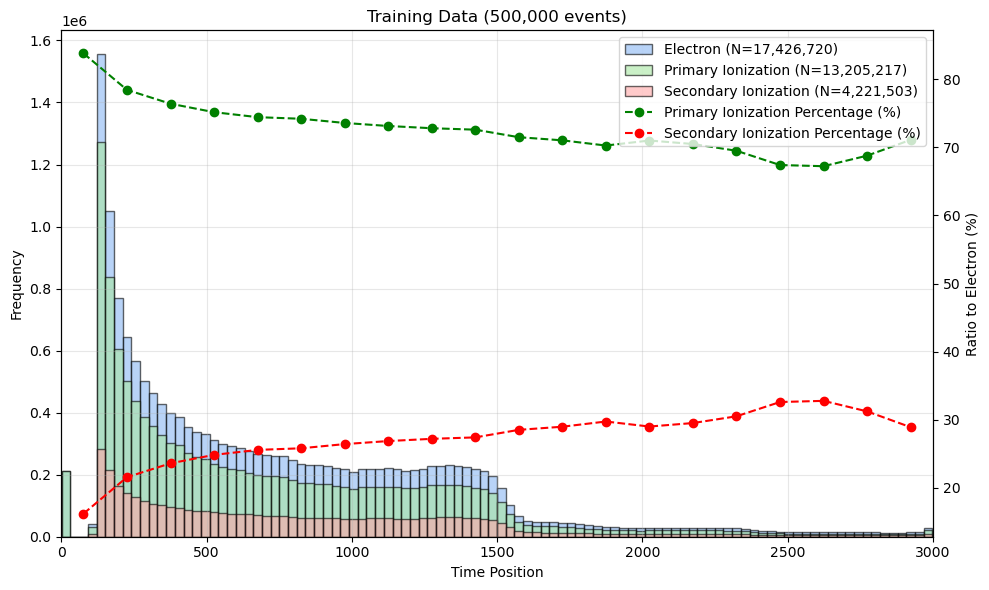

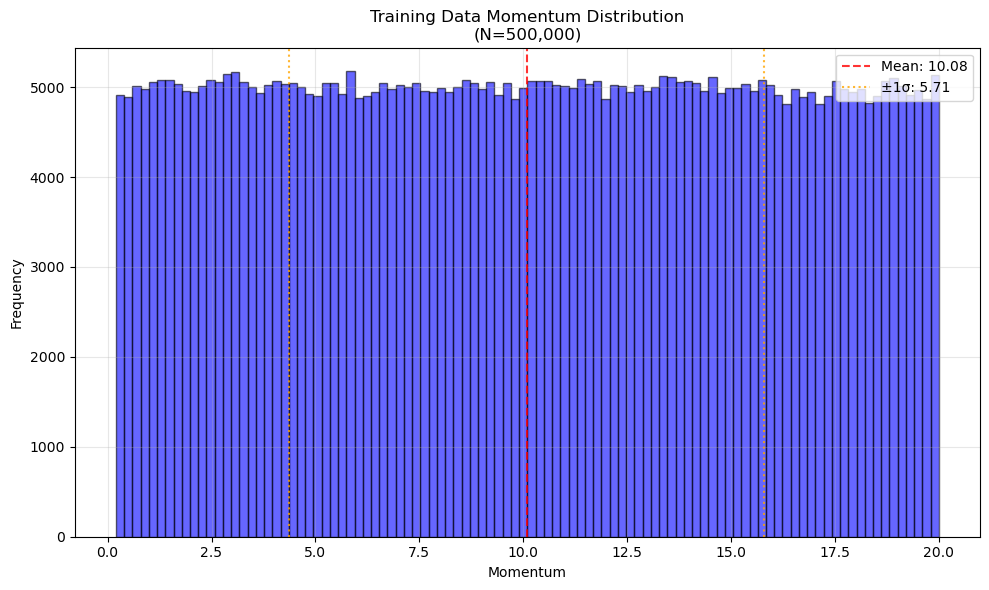

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def momentum_histogram_plot(train_data):
    plt.figure(figsize=(10, 6))

    plt.hist(train_data['mom'], bins=100, alpha=0.6, color='blue', edgecolor='black')
    plt.title(f'Training Data Momentum Distribution\n(N={len(train_data["mom"]):,})')
    plt.xlabel('Momentum')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    train_mean = np.mean(train_data['mom'])
    train_std = np.std(train_data['mom'])
    plt.axvline(train_mean, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean: {train_mean:.2f}')
    plt.axvline(train_mean + train_std, color='orange', linestyle=':', alpha=0.8)
    plt.axvline(train_mean - train_std, color='orange', linestyle=':', alpha=0.8, 
                label=f'±1σ: {train_std:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_tag_distributions(train_data):
    # 图 1: tag_times（非零）
    train_times_nonzero = train_data['tag_times'][train_data['tag_times'] > 0]

    plt.figure(figsize=(8, 5))
    plt.hist(train_times_nonzero, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Training Data: tag_times Distribution\n(Non-zero values, N={len(train_times_nonzero):,})')
    plt.xlabel('Time Position')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 图 2: tag_values（全部值）
    train_values_flat = train_data['tag_values'].flatten()
    unique_train_values, train_counts = np.unique(train_values_flat, return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(unique_train_values, train_counts, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Training Data: tag_values Distribution\n(All values, N={len(train_values_flat):,})')
    plt.xlabel('Tag Value')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    for val, count in zip(unique_train_values, train_counts):
        plt.text(val, count, f'{count:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



def plot_tag_times_by_value_category(train_data):
    tag_values = train_data['tag_values']
    tag_times = train_data['tag_times']

    raw_peaks = tag_times[tag_values > 0]
    primary = tag_times[tag_values == 1]
    secondary = tag_times[tag_values == 2]

    # Histogram: 100 bins (raw display)
    hist_bins = 100
    all_data = np.concatenate([raw_peaks, primary, secondary])
    hist_bin_edges = np.histogram_bin_edges(all_data, bins=hist_bins)

    # Ratio calculation: 20 bins
    ratio_bins = 20
    ratio_bin_edges = np.histogram_bin_edges(all_data, bins=ratio_bins)
    ratio_bin_centers = (ratio_bin_edges[:-1] + ratio_bin_edges[1:]) / 2

    raw_counts_ratio, _ = np.histogram(raw_peaks, bins=ratio_bin_edges)
    primary_counts, _ = np.histogram(primary, bins=ratio_bin_edges)
    secondary_counts, _ = np.histogram(secondary, bins=ratio_bin_edges)

    raw_counts_safe = np.where(raw_counts_ratio == 0, 1e-6, raw_counts_ratio)
    primary_ratio = 100 * primary_counts / raw_counts_safe
    secondary_ratio = 100 * secondary_counts / raw_counts_safe

    plt.figure(figsize=(10, 6))

    # Plot histograms
    plt.hist(raw_peaks, bins=hist_bin_edges, alpha=0.6, label=f'Electron (N={len(raw_peaks):,})', color='#8AB6F2', edgecolor='black')
    plt.hist(primary, bins=hist_bin_edges, alpha=0.6, label=f'Primary Ionization (N={len(primary):,})', color='#A8E6A3', edgecolor='black')
    plt.hist(secondary, bins=hist_bin_edges, alpha=0.6, label=f'Secondary Ionization (N={len(secondary):,})', color='#FFA8A8', edgecolor='black')

    # Ratio plot (twin y-axis)
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax2.plot(ratio_bin_centers, primary_ratio, color='green', linestyle='--', marker='o', label='Primary Ionization Percentage (%)')
    ax2.plot(ratio_bin_centers, secondary_ratio, color='red', linestyle='--', marker='o', label='Secondary Ionization Percentage (%)')

    ax1.set_xlim(0, 3000)
    ax2.set_xlim(0, 3000)

    ax1.set_xlabel('Time Position')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Ratio to Electron (%)')

    ax1.set_title('Training Data (500,000 events)')
    ax1.grid(True, alpha=0.3)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()




plot_tag_times_by_value_category(data)
momentum_histogram_plot(data)


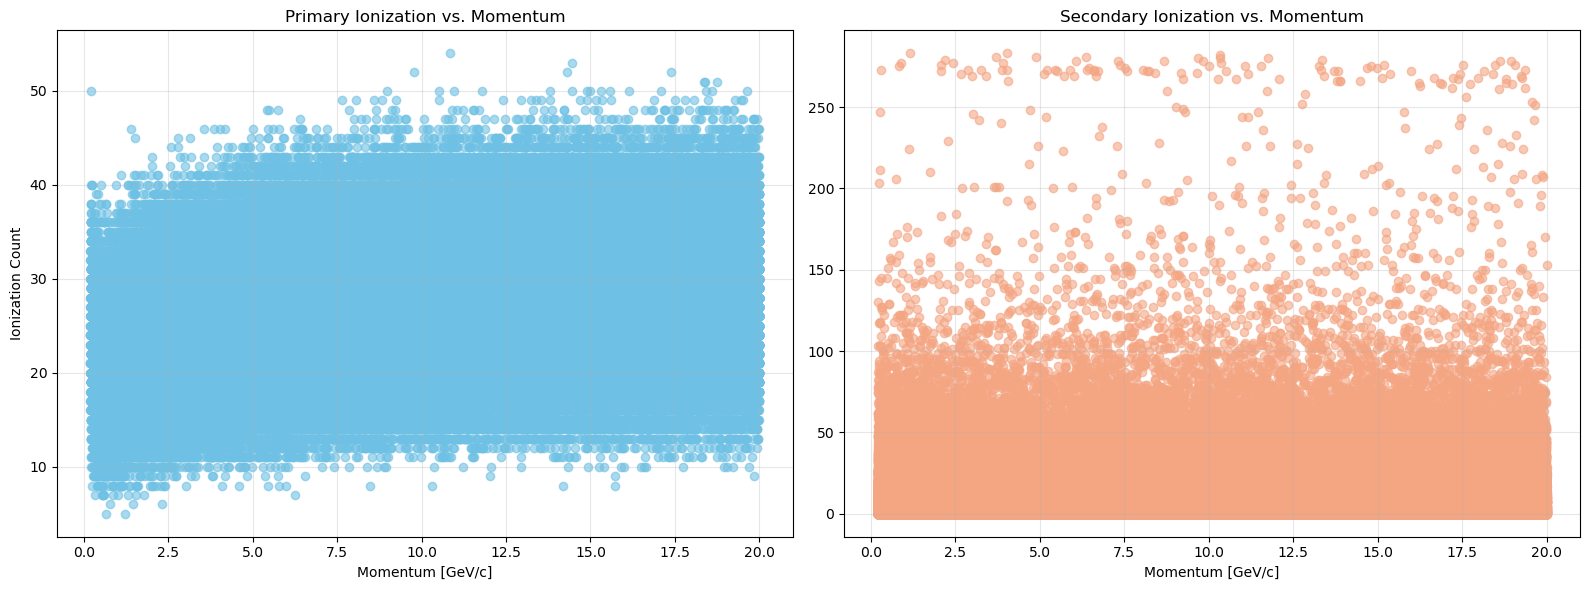

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ionization_vs_momentum_side_by_side(data):
    mom = data['mom']
    tag_values = data['tag_values']

    primary_counts = np.sum(tag_values == 1, axis=1)
    secondary_counts = np.sum(tag_values == 2, axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)

    axes[0].scatter(mom, primary_counts, color='#6EC1E4', alpha=0.6)
    axes[0].set_title('Primary Ionization vs. Momentum')
    axes[0].set_xlabel('Momentum [GeV/c]')
    axes[0].set_ylabel('Ionization Count')
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(mom, secondary_counts, color='#F4A582', alpha=0.6)
    axes[1].set_title('Secondary Ionization vs. Momentum')
    axes[1].set_xlabel('Momentum [GeV/c]')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_ionization_vs_momentum_side_by_side(data)


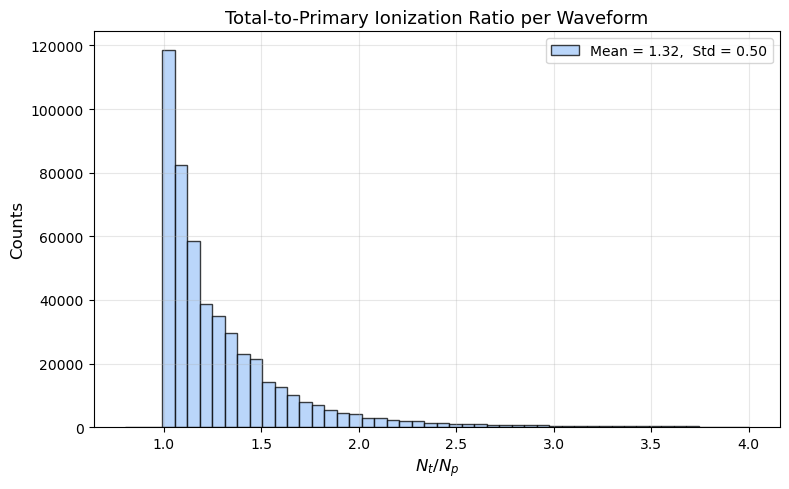

In [42]:
import numpy as np
import matplotlib.pyplot as plt

tag_values = data['tag_values']

nonzero_counts = np.sum(tag_values != 0, axis=1)
primary_counts = np.sum(tag_values == 1, axis=1)

valid_indices = primary_counts > 0
Nt_Np_ratio = nonzero_counts[valid_indices] / primary_counts[valid_indices]

mean_ratio = np.mean(Nt_Np_ratio)
std_ratio = np.std(Nt_Np_ratio)

plt.figure(figsize=(8, 5))
plt.hist(Nt_Np_ratio, bins=50, range=(0.8, 4), alpha=0.75, color='#A3C9F9', edgecolor='black',
         label=f'Mean = {mean_ratio:.2f},  Std = {std_ratio:.2f}')
plt.xlabel(r'$N_t / N_p$', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Total-to-Primary Ionization Ratio per Waveform', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((tlength,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    data[times] = values

    if ohe:
        ohe_data = np.zeros((tlength, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

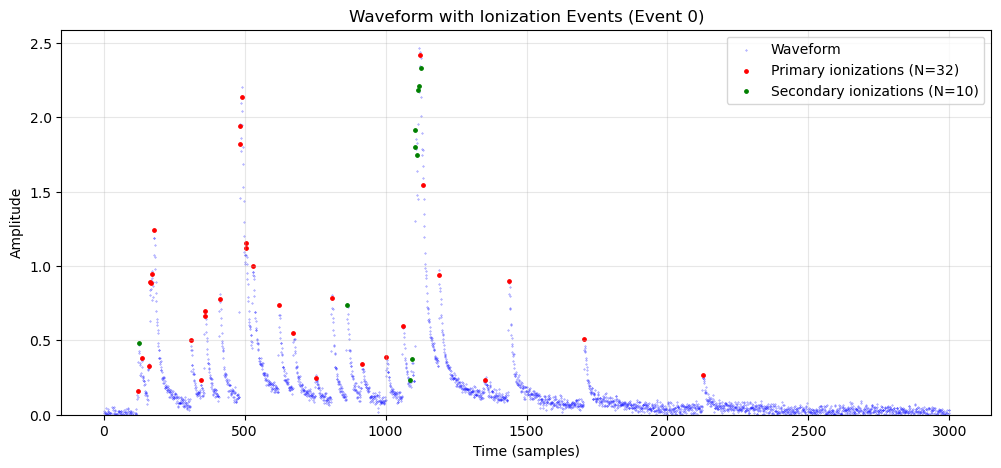

In [8]:
iev = 0
plt.figure(figsize=(12, 5))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

primary_mask = data['tag_values'][iev] == 1
plt.scatter(data['tag_times'][iev, primary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, primary_mask]], 
           s=6, color='r', label=f'Primary ionizations (N={np.sum(primary_mask)})')

secondary_mask = data['tag_values'][iev] == 2
plt.scatter(data['tag_times'][iev, secondary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, secondary_mask]], 
           s=6, color='g', label=f'Secondary ionizations (N={np.sum(secondary_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()